In [1]:
from lxml import html
import requests
import os
import pandas as pd
import glob
import subprocess
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
ROOT_URL = "http://www.epcc.ed.ac.uk/msc/programmes/programme-structure/dissertation"
BASE_URL = "http://www.epcc.ed.ac.uk"
TARGET_DIR = "dissertations"

# Scraping dissertations

In [3]:
def get_dissertation_pages(root_url, base_url):
    page = requests.get(ROOT_URL)
    tree = html.fromstring(page.content)
    return [base_url + _.attrib["href"] for _ in tree.xpath(".//div[@property='content:encoded']/ul/li/a")[1:]]

In [4]:
dissertation_pages = get_dissertation_pages(ROOT_URL, BASE_URL)

In [5]:
def get_pdf_urls(dissertation_page, prefix="http://"):
    page = requests.get(dissertation_page)
    tree = html.fromstring(page.content)
    return [prefix + _.attrib["href"][2:] for _ in tree.xpath(".//div[@property='content:encoded']/ul/li/a")]

In [6]:
urls = {}
for dp in dissertation_pages:
    year = dp.rsplit("/", 1)[1]
    urls[year] = get_pdf_urls(dp)
    print "{0}: {1} dissertation(s)".format(year, len(urls[year]))

2014-2015: 11 dissertation(s)
2013-2014: 17 dissertation(s)
2012-2013: 25 dissertation(s)
2011-2012: 21 dissertation(s)
2010-2011: 32 dissertation(s)
2009-2010: 20 dissertation(s)
2008-2009: 14 dissertation(s)
2007-2008: 22 dissertation(s)
2006-2007: 16 dissertation(s)
2005-2006: 17 dissertation(s)
2004-2005: 10 dissertation(s)
2003-2004: 9 dissertation(s)
2002-2003: 8 dissertation(s)
2001-2002: 2 dissertation(s)


In [7]:
def download_pdfs(urls, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
        
    for year in urls:
        print "Processing year {0}".format(year)
        
        year_dir = target_dir + os.sep + year
        if not os.path.exists(year_dir):
            os.makedirs(year_dir)
            
        for url in urls[year]:
            filename = url.rsplit("/", 1)[1]
            filepath = year_dir + os.sep + filename
            
            if not os.path.exists(filepath):
                print "Download {0}".format(filepath)
            
                r = requests.get(url)
                with open(filepath, "wb") as outfile:
                    outfile.write(r.content)

In [8]:
download_pdfs(urls, TARGET_DIR)

Processing year 2009-2010
Processing year 2002-2003
Processing year 2013-2014
Processing year 2005-2006
Processing year 2007-2008
Processing year 2014-2015
Processing year 2004-2005
Processing year 2003-2004
Processing year 2001-2002
Processing year 2011-2012
Processing year 2006-2007
Processing year 2010-2011
Processing year 2008-2009
Processing year 2012-2013


In [9]:
def pdf_to_txt(pdfpath):
    if not os.path.exists(pdfpath[:-4] + ".txt"):
        subprocess.call("pdftotext " + pdfpath, shell=True)
    
for pdf in glob.glob(TARGET_DIR + "/*/*.pdf"):
    print pdf
    pdf_to_txt(pdf)

dissertations/2001-2002/ajackson.pdf
dissertations/2001-2002/jhill.pdf
dissertations/2002-2003/1944495_12b-1.1.pdf
dissertations/2002-2003/2450669_12b-1.1.pdf
dissertations/2002-2003/2453500_12b-1.1.pdf
dissertations/2002-2003/2453672_12b-1.1.pdf
dissertations/2002-2003/2453683_12b-1.3.pdf
dissertations/2002-2003/2456009_12b-1.1.pdf
dissertations/2002-2003/2456502_12b-1.1.pdf
dissertations/2002-2003/2456505_12b-1.1.pdf
dissertations/2003-2004/1021818_12b-1.1.pdf
dissertations/2003-2004/2561612_12b-1.1.pdf
dissertations/2003-2004/2561806_12b-1.2.pdf
dissertations/2003-2004/2562962_12b-1.2.pdf
dissertations/2003-2004/2562964_12b-1.2.pdf
dissertations/2003-2004/2565516_12b-1.1.pdf
dissertations/2003-2004/2565606_12b-1.1.pdf
dissertations/2003-2004/2566945_12b-1.1.pdf
dissertations/2003-2004/2567653_12b-1.2.pdf
dissertations/2004-2005/0308429-9j-dissertation1.1.pdf
dissertations/2004-2005/0762240-9j-dissertation1.1.pdf
dissertations/2004-2005/0764527-9j-dissertation1.2.pdf
dissertations/20

# Analysis

## Dissertations per year

,count,mean,std,min,25%,50%,75%,max
0,14,16,7.795462,2,10.25,16.5,20.75,32


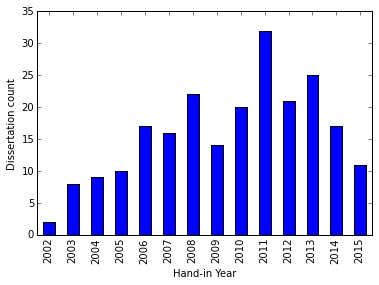

In [10]:
counts = {}
for year in sorted(urls):
    second_year = int(year.rsplit("-", 1)[1])
    counts[second_year] = len(urls[year])
df = pd.DataFrame(pd.Series(counts))
ax = df.plot(kind="bar", legend=None)
ax.set_xlabel("Hand-in Year")
ax.set_ylabel("Dissertation count")
df.describe().transpose()

## Length of dissertations
Needs work - GNU wc probably counts afaik space separated tokens

In [11]:
wordcounts = {}
for txt in glob.glob(TARGET_DIR + "/*/*.txt"):
    wc = int(subprocess.check_output("wc -w '" + txt + "'", shell=True).split()[0])
    wordcounts[txt] = wc

,count,mean,std,min,25%,50%,75%,max
0,194,21793.149485,10274.163908,6374,15697.5,19458,24945.75,78685


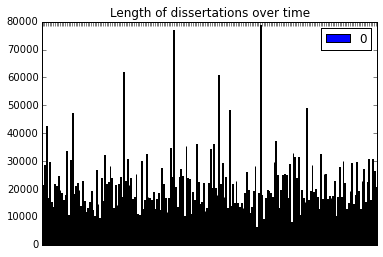

In [12]:
df = pd.DataFrame(pd.Series(wordcounts))
ax = df.plot(kind="bar", title="Length of dissertations over time")
ax.xaxis.set_ticklabels([])
df.describe().transpose()

In [15]:
words = "Proeme", "Nick Johnson", "Nicholas Johnson", "Visualisation"
for pdf in glob.glob(TARGET_DIR + "/*/*.txt"):
    with open(pdf, 'r') as fi:
        content = fi.read()
    for _ in words:
        if _ in content:
            print _, pdf
            break
            

Visualisation dissertations/2002-2003/2453672_12b-1.1.txt
Visualisation dissertations/2004-2005/0762240-9j-dissertation1.1.txt
Visualisation dissertations/2005-2006/3365198-9a-dissertation1.3.txt
Visualisation dissertations/2006-2007/0459988.txt
Visualisation dissertations/2006-2007/6547365-27d-d07rep1.2.txt
Visualisation dissertations/2006-2007/Geraldine-McKenna.txt
Visualisation dissertations/2008-2009/Antonia_Collis.txt
Visualisation dissertations/2009-2010/Daniel%20Wilde.txt
Visualisation dissertations/2009-2010/Stefan%20Wysocki.txt
Visualisation dissertations/2010-2011/PaulRoss.txt
Visualisation dissertations/2010-2011/ThomasRichard.txt
Visualisation dissertations/2010-2011/VinodhVedachalam.txt
Visualisation dissertations/2011-2012/Submission-1147228.txt
Visualisation dissertations/2012-2013/Point%20Cloud%20Visualisation.txt
Visualisation dissertations/2012-2013/Visual%20Parallel%20Programming.txt
